In [28]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer#, KNNImputer#, IterativeImputer
from sklearn.compose import ColumnTransformer

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
# set options to make data easier to view in Jupyter Notebook
pd.set_option("display.max_columns", 100)

# print numbers in pd.DataFrame (instead of scientific notation)
pd.set_option('display.precision', 12)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# set random seed to ensure reproducible results
np.random.seed(42)

In [3]:
initial_features_df = pd.read_csv('../data/training_set_features.csv')
initial_labels_df = pd.read_csv('../data/training_set_labels.csv')

In [4]:
# drop columns that are not useful for training model
initial_features_df.drop(columns=[
    'respondent_id', 'h1n1_concern', 'h1n1_knowledge', 'doctor_recc_h1n1', 
    'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc'
], inplace=True)

In [5]:
X = initial_features_df.copy()
y = initial_labels_df['seasonal_vaccine']

# Impute

In [6]:
def grab_numeric(df):
    return df.select_dtypes(include=np.number)

def grab_object(df):
    return df.select_dtypes(exclude=np.number)

def grab_select_columns(df, columns):
    return df[columns]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [8]:
GrabNumeric = FunctionTransformer(grab_numeric)
GrabObject = FunctionTransformer(grab_object)

In [9]:
# We need to impute NaNs for health_insurance first, so that they won't be imputed by subsequent steps
# Changing missing values to 0, but adding indicator column. Entering both columns into models should account
# for differences between imputed 0's and true 0's
subpipe_constant = Pipeline(steps=[
    ('get_select_columns', FunctionTransformer(grab_select_columns, kw_args={'columns':['health_insurance']})),
    ('constant_imputer', SimpleImputer(strategy="constant", fill_value=0, add_indicator=True))
])

# Numeric columns don't need OneHotEncoding (opinion and household vars are ordinal, other vars are binary)
subpipe_num = Pipeline(steps=[
    ('get_num', GrabNumeric),
    ('num_impute', SimpleImputer(strategy='most_frequent')),
    ('ss', StandardScaler())
])

subpipe_cat = Pipeline(steps=[
    ('get_obj', GrabObject),
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore')),
    ('ss', StandardScaler())
])

In [10]:
ct = ColumnTransformer(transformers = [
    ('subpipe_constant', subpipe_constant, X_train.columns),
    ('subpipe_num', subpipe_num, X_train.columns),
    ('subpipe_cat', subpipe_cat, X_train.columns)
])

In [11]:
# It would be nice to use something more sophisticated to impute health_insurance, 
# but I can't figure it out right now

# subpipe_knn = Pipeline(steps=[
#     ('get_select_columns', FunctionTransformer(grab_select_columns, kw_args={'columns':['health_insurance']})),
#     ('knn_imputer', KNNImputer(n_neighbors=1, add_indicator=True, copy=False))
# ])



# ct = ColumnTransformer(transformers = [
#     ('subpipe_knn', subpipe_knn, X_train.columns),
#     ('subpipe_num', subpipe_num, X_train.columns),
#     ('subpipe_cat', subpipe_cat, X_train.columns)
# ])

In [12]:
tmp = pd.DataFrame(ct.fit_transform(X_train))

In [13]:
print(f"Number of nulls: {tmp.isna().sum().sum()}")
display(tmp.describe())

Number of nulls: 0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
count,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,...,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00
mean,0.47,0.46,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,...,0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
std,0.50,0.50,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,0.00,0.00,-0.23,-1.63,-0.27,-2.16,-0.74,-0.71,-1.44,-0.66,-0.61,-0.29,-0.35,-3.82,-2.82,-1.24,-0.83,-1.19,-0.57,-0.50,-0.41,-0.49,-0.51,-0.59,-0.53,-0.31,-0.87,-0.60,-0.29,-0.26,-0.26,-1.98,-1.22,-0.82,-1.35,-0.58,-0.33,-1.13,-0.88,-1.88,-0.53,-1.13,-0.79,-0.24,-0.29,-0.34,-0.21,-0.37,-0.35,-0.29,...,-0.30,-0.35,-0.36,-0.88,-0.65,-0.61,-0.18,-0.19,-0.11,-0.08,-1.21,-0.08,-0.22,-0.10,-0.15,-0.07,-0.10,-0.06,-0.20,-0.02,-0.14,-0.11,-0.14,-0.09,-0.27,-0.18,-0.14,-0.11,-0.12,-0.22,-0.08,-0.09,-0.22,-0.11,-0.17,-0.09,-0.14,-0.25,-0.11,-0.06,-0.15,-0.10,-0.12,-0.12,-0.13,-0.12,-0.21,-0.14,-1.15,-0.10
25%,0.00,0.00,-0.23,-1.63,-0.27,0.46,-0.74,-0.71,-1.44,-0.66,-0.61,-0.29,-0.35,0.26,-0.03,-0.51,-0.83,-1.19,-0.57,-0.50,-0.41,-0.49,-0.51,-0.59,-0.53,-0.31,-0.87,-0.60,-0.29,-0.26,-0.26,0.51,-1.22,-0.82,-1.35,-0.58,-0.33,-1.13,-0.88,0.53,-0.53,-1.13,-0.79,-0.24,-0.29,-0.34,-0.21,-0.37,-0.35,-0.29,...,-0.30,-0.35,-0.36,-0.88,-0.65,-0.61,-0.18,-0.19,-0.11,-0.08,-1.21,-0.08,-0.22,-0.10,-0.15,-0.07,-0.10,-0.06,-0.20,-0.02,-0.14,-0.11,-0.14,-0.09,-0.27,-0.18,-0.14,-0.11,-0.12,-0.22,-0.08,-0.09,-0.22,-0.11,-0.17,-0.09,-0.14,-0.25,-0.11,-0.06,-0.15,-0.10,-0.12,-0.12,-0.13,-0.12,-0.21,-0.14,-1.15,-0.10
50%,0.00,0.00,-0.23,0.61,-0.27,0.46,-0.74,-0.71,0.69,-0.66,-0.61,-0.29,-0.35,0.26,-0.03,-0.51,-0.07,0.15,-0.57,-0.50,-0.41,-0.49,-0.51,-0.59,-0.53,-0.31,-0.87,-0.60,-0.29,-0.26,-0.26,0.51,0.82,-0.82,0.74,-0.58,-0.33,0.88,-0.88,0.53,-0.53,0.88,-0.79,-0.24,-0.29,-0.34,-0.21,-0.37,-0.35,-0.29,...,-0.30,-0.35,-0.36,-0.88,-0.65,-0.61,-0.18,-0.19,-0.11,-0.08,0.83,-0.08,-0.22,-0.10,-0.15,-0.07,-0.10,-0.06,-0.20,-0.02,-0.14,-0.11,-0.14,-0.09,-0.27,-0.18,-0.14,-0.11,-0.12,-0.22,-0.08,-0.09,-0.22,-0.11,-0.17,-0.09,-0.14,-0

# Prepare to run models

In [54]:
# initialize lists to store model outputs
models = []
results = []
names = []
scoring="roc_auc"

In [56]:
### This class came from Lecture 51
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True, scoring="accuracy"):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds, scoring=scoring)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} {scoring}
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

# DummyClassifier model

In [57]:
dummy_model_pipe = Pipeline(steps=[
    ('ct',ct),
    ('dum_class', DummyClassifier(strategy='most_frequent'))
])
dummy_cv = ModelWithCV(dummy_model_pipe, model_name='dummy_model_pipe', X=X_train, y=y_train)

CV Results for `dummy_model_pipe` model:
            0.50000 ± 0.00000 roc_auc
        


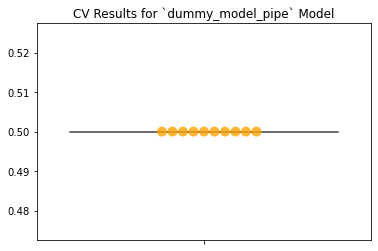

In [58]:
dummy_cv.print_cv_summary()
fig, ax = plt.subplots()

dummy_cv.plot_cv(ax=ax);

# Random Forest Classifier

In [59]:
rfc = RandomForestClassifier()

rfc_model_pipe = Pipeline([
    ('ct', ct),
    ('rfc', rfc)
])

In [60]:
rfc_defaults_cv = ModelWithCV(rfc_model_pipe, model_name='rfc_defaults_model_pipe', X=X_train, y=y_train)

CV Results for `rfc_defaults_model_pipe` model:
            0.84663 ± 0.01041 roc_auc
        


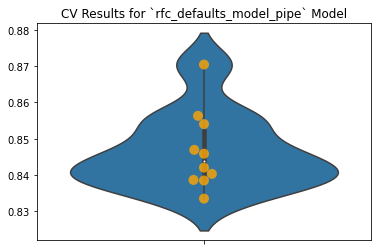

In [61]:
rfc_defaults_cv.print_cv_summary()

fig, ax = plt.subplots()
rfc_defaults_cv.plot_cv(ax=ax);

## GridSearchCV on Random Forest Classifier

In [64]:
params = {
    'rfc__n_estimators': [500, 750, 1000]
    ,'rfc__max_depth': [5, 15, 25]
    ,'rfc__max_features': [5, 15, 25]
    ,'rfc__min_samples_leaf': [1, 3, 5]
    ,'rfc__min_samples_split': [4, 8, 12]
}

In [65]:
%%time
gs_cv1 = GridSearchCV(estimator=rfc_model_pipe, scoring=scoring, param_grid=params, cv=5, n_jobs=-2)
gs_cv1.fit(X_train,y_train)

CPU times: user 38.4 s, sys: 1.2 s, total: 39.6 s
Wall time: 1h 6min 54s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_constant',
                                                                         Pipeline(steps=[('get_select_columns',
                                                                                          FunctionTransformer(func=<function grab_select_columns at 0x7f8128490940>,
                                                                                                              kw_args={'columns': ['health_insurance']})),
                                                                                         ('constant_imputer',
                                                                                          SimpleImputer(add_indicator=True,
                                                                                                        fill_value=0,
                                                          

In [80]:
gs_cv1.best_params_

{'rfc__max_depth': 15,
 'rfc__max_features': 15,
 'rfc__min_samples_leaf': 1,
 'rfc__min_samples_split': 12,
 'rfc__n_estimators': 750}

In [81]:
gs_cv1.best_score_

0.8548331894681434

In [79]:
import pickle
# save the model to disk
filename = '/Users/gburgess/Documents/Flatiron/projects/project3/Predicting_Vaccinations/data/rfc_gs_cv1_model.sav'
pickle.dump(gs_cv1, open(filename, 'wb'))

In [82]:
params = {
    'rfc__n_estimators': [750]
    ,'rfc__max_depth': [10, 15, 20]
    ,'rfc__max_features': [10, 15, 20]
    ,'rfc__min_samples_leaf': [1, 2]
    ,'rfc__min_samples_split': [10, 12, 15, 20]
}

In [83]:
%%time
gs_cv2 = GridSearchCV(estimator=rfc_model_pipe, scoring=scoring, param_grid=params, cv=5, n_jobs=-2)
gs_cv2.fit(X_train,y_train)

CPU times: user 23.1 s, sys: 785 ms, total: 23.9 s
Wall time: 21min 37s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_constant',
                                                                         Pipeline(steps=[('get_select_columns',
                                                                                          FunctionTransformer(func=<function grab_select_columns at 0x7f8128490940>,
                                                                                                              kw_args={'columns': ['health_insurance']})),
                                                                                         ('constant_imputer',
                                                                                          SimpleImputer(add_indicator=True,
                                                                                                        fill_value=0,
                                                          

In [84]:
gs_cv2.best_params_

{'rfc__max_depth': 15,
 'rfc__max_features': 15,
 'rfc__min_samples_leaf': 1,
 'rfc__min_samples_split': 15,
 'rfc__n_estimators': 750}

In [85]:
gs_cv2.best_score_

0.8551843912449886

In [86]:
# save the model to disk
filename = '/Users/gburgess/Documents/Flatiron/projects/project3/Predicting_Vaccinations/data/rfc_gs_cv2_model.sav'
pickle.dump(gs_cv2, open(filename, 'wb'))

## Logistic Regression

In [66]:
from sklearn.linear_model import LogisticRegression

In [67]:
logreg = LogisticRegression()

logreg_model_pipe = Pipeline([
    ('ct', ct),
    ('logreg', logreg)
])

In [68]:
logreg_defaults_cv = ModelWithCV(
    logreg_model_pipe, 
    model_name='logreg_defaults_model_pipe', 
    X=X_train, y=y_train, 
    scoring=scoring
)

CV Results for `logreg_defaults_model_pipe` model:
            0.85289 ± 0.01015 roc_auc
        


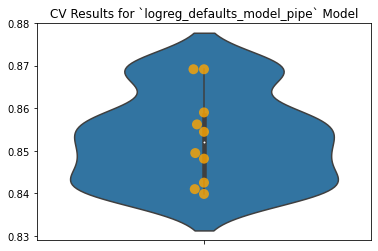

In [69]:
logreg_defaults_cv.print_cv_summary()

fig, ax = plt.subplots()
logreg_defaults_cv.plot_cv(ax=ax);

## GridSearchCV on Logistic Regression

In [73]:
params = {
    'logreg__penalty': ['l1', 'l2', 'elasticnet']
    ,'logreg__C': [100, 10, 1.0, 0.1, 0.01]
    ,'logreg__solver': ['saga']
    ,'logreg__max_iter': [500, 1000]
}

In [74]:
%%time
logreg_gs_cv1 = GridSearchCV(estimator=logreg_model_pipe, scoring=scoring, param_grid=params, cv=5, n_jobs=-2)
logreg_gs_cv1.fit(X_train,y_train)

CPU times: user 12.3 s, sys: 197 ms, total: 12.5 s
Wall time: 1min 45s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_constant',
                                                                         Pipeline(steps=[('get_select_columns',
                                                                                          FunctionTransformer(func=<function grab_select_columns at 0x7f8128490940>,
                                                                                                              kw_args={'columns': ['health_insurance']})),
                                                                                         ('constant_imputer',
                                                                                          SimpleImputer(add_indicator=True,
                                                                                                        fill_value=0,
                                                          

In [76]:
logreg_gs_cv1.best_params_

{'logreg__C': 0.1,
 'logreg__max_iter': 500,
 'logreg__penalty': 'l1',
 'logreg__solver': 'saga'}

In [78]:
logreg_gs_cv1.best_score_

0.8529985801359642

In [77]:
import pickle
# save the model to disk
filename = '/Users/gburgess/Documents/Flatiron/projects/project3/Predicting_Vaccinations/data/logreg_gs_cv1_model.sav'
pickle.dump(logreg_gs_cv1, open(filename, 'wb'))

In [34]:
gs_cv1.cv_results_['mean_test_score']

array([0.72121817, 0.73215177, 0.73734398, 0.72456316, 0.72920619,
       0.73230155, 0.73210185, 0.73330005, 0.73095357, 0.72446331,
       0.73130305, 0.7333999 , 0.72940589, 0.73050424, 0.73185222,
       0.72451323, 0.73290065, 0.72935597, 0.73364953, 0.73070394,
       0.7316026 , 0.72810784, 0.72975537, 0.73349975, 0.72815776,
       0.73165252, 0.73285072, 0.74163754, 0.74278582, 0.7465302 ,
       0.74483275, 0.7457314 , 0.74543185, 0.7427359 , 0.7457314 ,
       0.74707938, 0.7443335 , 0.74268597, 0.74777833, 0.74138792,
       0.74468298, 0.7465302 , 0.74083874, 0.75037444, 0.7447329 ,
       0.74503245, 0.74897654, 0.74677983, 0.7457314 , 0.74707938,
       0.74643035, 0.74238642, 0.74648028, 0.74717923, 0.74967549,
       0.74927609, 0.75202197, 0.74777833, 0.75112332, 0.75227159,
       0.74732901, 0.74947579, 0.75027459, 0.74947579, 0.74752871,
       0.74942586, 0.74947579, 0.75272092, 0.75207189, 0.743335  ,
       0.74967549, 0.75167249, 0.74483275, 0.74942586, 0.75182

In [35]:
gs_cv1.best_estimator_

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_constant',
                                                  Pipeline(steps=[('get_select_columns',
                                                                   FunctionTransformer(func=<function grab_select_columns at 0x7f8128490940>,
                                                                                       kw_args={'columns': ['health_insurance']})),
                                                                  ('constant_imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 fill_value=0,
                                                                                 strategy='constant'))]),
                                                  Index(['behavioral_antiviral_meds'...
       'opinion_seas_sick_from_vacc', 'age_group', 'education', 'ra

In [36]:
%%time
params = {
    'rfc__max_depth': [15, 20, 30, 50]
    ,'rfc__max_features': [3, 5, 10]
    ,'rfc__min_samples_leaf': [1, 2, 3]
    ,'rfc__min_samples_split': [4, 6, 8]
    ,'rfc__n_estimators': [400, 500, 1000]
}

gs_cv2 = GridSearchCV(estimator=rfc_model_pipe, param_grid=params, cv=5, n_jobs=-2)
gs_cv2.fit(X_train,y_train)

CPU times: user 38.8 s, sys: 1.54 s, total: 40.4 s
Wall time: 57min 24s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_constant',
                                                                         Pipeline(steps=[('get_select_columns',
                                                                                          FunctionTransformer(func=<function grab_select_columns at 0x7f8128490940>,
                                                                                                              kw_args={'columns': ['health_insurance']})),
                                                                                         ('constant_imputer',
                                                                                          SimpleImputer(add_indicator=True,
                                                                                                        fill_value=0,
                                                          

In [39]:
%store gs

Stored 'gs' (GridSearchCV)


In [40]:
gs_cv2.cv_results_['mean_test_score']

array([0.76814778, 0.766001  , 0.7671992 , 0.76669995, 0.76829755,
       0.7662007 , 0.7671992 , 0.76749875, 0.76724913, 0.76650025,
       0.76515227, 0.76625062, 0.76729905, 0.76744883, 0.7666001 ,
       0.76645032, 0.76645032, 0.76555167, 0.76585122, 0.76430354,
       0.76615077, 0.76550175, 0.7662007 , 0.76450325, 0.76435347,
       0.76625062, 0.76555167, 0.77319021, 0.77264104, 0.77363954,
       0.77304044, 0.77393909, 0.77388917, 0.77184224, 0.77239141,
       0.77214179, 0.77274089, 0.77304044, 0.77249126, 0.77398902,
       0.77294059, 0.77388917, 0.77199201, 0.77284074, 0.77209186,
       0.77338992, 0.77189216, 0.77224164, 0.77229156, 0.77274089,
       0.77244134, 0.77279081, 0.77254119, 0.77284074, 0.77503744,
       0.77548677, 0.77703445, 0.7757364 , 0.7769346 , 0.77728407,
       0.77623565, 0.77758362, 0.77738392, 0.77663505, 0.77728407,
       0.77618572, 0.77738392, 0.77583625, 0.77758362, 0.77643535,
       0.77578632, 0.77658512, 0.77668497, 0.77743385, 0.77628

In [41]:
gs_cv2.best_estimator_

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_constant',
                                                  Pipeline(steps=[('get_select_columns',
                                                                   FunctionTransformer(func=<function grab_select_columns at 0x7f8128490940>,
                                                                                       kw_args={'columns': ['health_insurance']})),
                                                                  ('constant_imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 fill_value=0,
                                                                                 strategy='constant'))]),
                                                  Index(['behavioral_antiviral_meds'...
       'opinion_seas_sick_from_vacc', 'age_group', 'education', 'ra

In [42]:
%%time
params = {
    'rfc__max_depth': [15]
    ,'rfc__max_features': [10, 15, 20]
    ,'rfc__min_samples_split': [8]
    ,'rfc__n_estimators': [500, 600, 700]
}

gs_cv3 = GridSearchCV(estimator=rfc_model_pipe, param_grid=params, cv=5, n_jobs=-2)
gs_cv3.fit(X_train,y_train)

CPU times: user 17.3 s, sys: 474 ms, total: 17.7 s
Wall time: 3min 7s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_constant',
                                                                         Pipeline(steps=[('get_select_columns',
                                                                                          FunctionTransformer(func=<function grab_select_columns at 0x7f8128490940>,
                                                                                                              kw_args={'columns': ['health_insurance']})),
                                                                                         ('constant_imputer',
                                                                                          SimpleImputer(add_indicator=True,
                                                                                                        fill_value=0,
                                                          

In [43]:
gs_cv3.best_estimator_

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_constant',
                                                  Pipeline(steps=[('get_select_columns',
                                                                   FunctionTransformer(func=<function grab_select_columns at 0x7f8128490940>,
                                                                                       kw_args={'columns': ['health_insurance']})),
                                                                  ('constant_imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 fill_value=0,
                                                                                 strategy='constant'))]),
                                                  Index(['behavioral_antiviral_meds'...
       'opinion_seas_sick_from_vacc', 'age_group', 'education', 'ra

In [48]:
gs_cv3.best_score_

0.7787818272591113

## Final Random Forest Classifier Model

In [62]:
rfc_optimized = RandomForestClassifier(
    max_depth=15, 
    max_features=15, 
    min_samples_split=8, 
    n_estimators=700
)

rfc_optimized_pipe = Pipeline([
    ('ct', ct),
    ('rfc_optimized', rfc_optimized)
])

rfc_optimized_cv = ModelWithCV(rfc_optimized_pipe, model_name='rfc_optimized_pipe', X=X_train, y=y_train, scoring=scoring)

CV Results for `rfc_optimized_pipe` model:
            0.85468 ± 0.01009 roc_auc
        


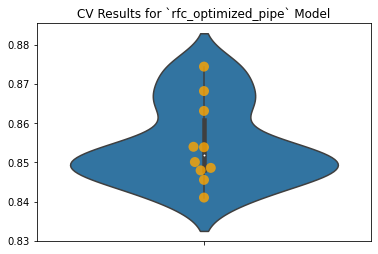

In [63]:
rfc_optimized_cv.print_cv_summary()

fig, ax = plt.subplots()
rfc_optimized_cv.plot_cv(ax=ax);